In [16]:
from losses import binary_crossentropy 
from tensorflow.keras.utils import plot_model
from eunet import build_EUNet
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import filters

## 1. Build Efficient U-Net 

In [17]:
model = build_EUNet(number_classes = 3, input_height = 256, input_width = 256)

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 128, 128, 13) 364         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 128, 16) 0           conv2d_156[0][0]                 
                                                                 max_pooling2d_4[0][0]      

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.050964 to fit



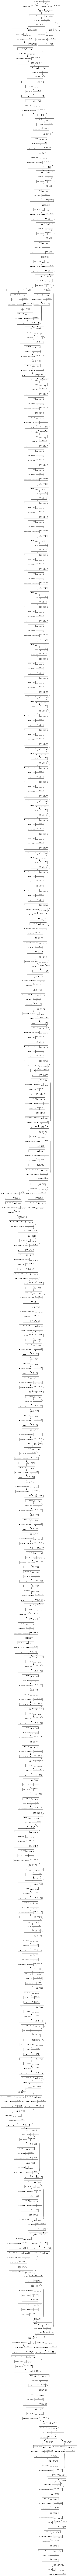

In [19]:
plot_model( model,
            to_file='model.png',
            show_shapes=True,
            show_layer_names=True,
            dpi=1024)

In [79]:
def gaussian_filter(image, sigma = 2):
    img = np.copy(image)
    blur = filters.gaussian(img, sigma=sigma)
    return blur

In [80]:
def binary(image, threshold, max_value = 1):
    img = np.copy(image)

    (t,masklayer) = cv2.threshold(img,threshold,max_value,cv2.THRESH_BINARY)
    return masklayer

In [81]:
def find_threshold_otsu(image):
    t = filters.threshold_otsu(image)
    return t

In [248]:
def load_image(s_image_path, gt_image_path):
    
    s_image_path=str(s_image_path).split("'")[1]
    gt_image_path=str(gt_image_path).split("'")[1]

    #print(s_image_path, gt_image_path)   
    s_image =cv2.imread(str(s_image_path))
    s_image= cv2.cvtColor(s_image,cv2.COLOR_BGR2RGB)

    #GT_path=str(GT_path).split("'")[1]
    gt_image =cv2.imread(str(gt_image_path))
    gt_image= cv2.cvtColor(gt_image,cv2.COLOR_BGR2RGB)



       
    if np.random.random() > 0.5:
     # random mirroring
        s_image = cv2.flip( s_image, -1);
        gt_image = cv2.flip( gt_image, -1);


        
    gt_image= cv2.cvtColor(gt_image,cv2.COLOR_RGB2GRAY)
     
        
    guass_img = gaussian_filter(gt_image, sigma =2)
    threshold =  find_threshold_otsu(guass_img)
    gt_image = binary(guass_img, threshold, max_value = 1)
    
    s_image = s_image / 255.0

    s_image = tf.cast(s_image, tf.float32)
    gt_image = tf.cast(gt_image, tf.float32)
    gt_image = tf.expand_dims( gt_image, 2)    


    return s_image,gt_image

In [249]:
Train_Dataset_dir = "/media/rima/C/Datasets/cut_tirol/Klein_Dataset2/train/"
Valid_Dataset_dir = "/media/rima/C/Datasets/cut_tirol/Klein_Dataset2/valid/"
Test_Dataset_dir = "/media/rima/C/Datasets/cut_tirol/Klein_Dataset2/test/"

In [250]:
Train_SB_dir, Train_GT_dir, SB_Train_listnames, GT_Train_listnames = prepare_dataset(Train_Dataset_dir) #load Satellite und Ground Truths Data
Valid_SB_dir, Valid_GT_dir, SB_Valid_listnames, GT_Valid_listnames= prepare_dataset(Valid_Dataset_dir)
Test_SB_dir, Test_GT_dir, SB_Test_listnames, GT_Test_listnames= prepare_dataset(Test_Dataset_dir)

Satellite Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/train/Croped_SB/
Number of  ground truths: 6876

Ground Truths Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/train/Croped_GT/
Number der satellien images: 6876
*********************************************
Satellite Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/valid/Croped_SB/
Number of  ground truths: 756

Ground Truths Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/valid/Croped_GT/
Number der satellien images: 756
*********************************************
Satellite Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/test/Croped_SB/
Number of  ground truths: 774

Ground Truths Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/test/Croped_GT/
Number der satellien images: 774
*********************************************


In [251]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
N_CHANNELS = 3
N_CLASSES = 1 #
BUFFER_SIZE =  2000

In [254]:
#train_dataset = tf.data.Dataset.from_tensor_slices(((SB_filenames, GT_filenames)))
SB_dataset_train = tf.data.Dataset.from_tensor_slices(SB_Train_listnames)
GT_dataset_train = tf.data.Dataset.from_tensor_slices(GT_Train_listnames)
train_dataset = tf.data.Dataset.zip((SB_dataset_train,GT_dataset_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

train_dataset = train_dataset.map(lambda x,y: tf.py_function(load_image, [x, y], [tf.float32,tf.float32]))

train_dataset = train_dataset.batch(10)

In [255]:
train_dataset.take(1)

<TakeDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>

(10, 256, 256, 3) (10, 256, 256, 1)


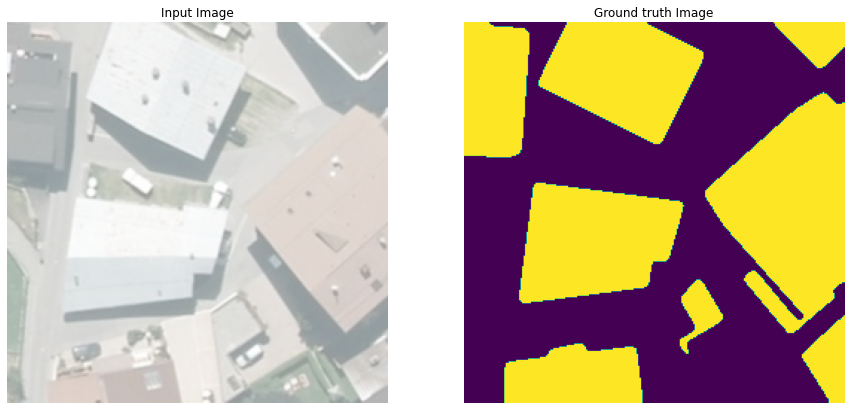

In [256]:
for SB, GT in train_dataset.take(1):
    plt.figure(figsize=(15,15))
    print(SB.shape, GT.shape)
    display_list=[SB[0,:,:,:,],GT[0,:,:,:,]]
    title = ['Input Image', 'Ground truth Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*.5+.5 )
        plt.axis('off')
    plt.show()